In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df['Keywords'] = df['Keywords'].str.split(',')

In [4]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Regression Problem: Predicting Student Performance, i.e., average score of correct answers

- Given the inputs: `Student Country, Question Levels, Topics, Subtopics and Keywords`, the goal is to predict the average score of correct answers of a student.
- We utilise these Regression models to solve this problem:
    - Linear Regression
    - Random Forest
    - Gradient Boosting
    - XGBoost

### Pre-processing

- Aggregate the data on Student ID, to get all the aggregated values for a student considering the questions they've answered.
- The aggregation is performed as follows:
    - Student Country: Since this stays the same for a student, we only consider the first value.
    - Obtain the unique values, then perform One-hot-encoding using Multi-label Binarizer for these variables:
        - Question Level
        - Topic
        - Subtopic
    - Use Tf-Idf Vectorizer as used in Classification for the Keywords.
    - The target variable: Average Score should be created using the simple formula: Correct_Answers/Total_Answers

In [5]:
aggregated_df = df.groupby("Student ID").agg(
    Student_Country=("Student Country", "first"),  # Keep first occurrence
    Correct_Answers=("Type of Answer", "sum"),  # Sum of 1s = correct answers
    Total_Answers=("Type of Answer", "count"),  # Count of total attempts
    Average_Score=("Type of Answer", "mean"),  # Mean = correct/total
    Question_Levels=("Question Level", lambda x: x.unique()),
    Topics=("Topic", lambda x: x.unique()),
    Subtopics=("Subtopic", lambda x: x.unique()),
    Keywords=("Keywords", lambda x: list(set([kw for sublist in x for kw in sublist])))  # Flatten & deduplicate
).reset_index()

In [6]:
aggregated_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Question_Levels,Topics,Subtopics,Keywords
0,26,Portugal,58,77,0.753247,[Basic],"[Linear Algebra, Differential Equations, Proba...","[Linear Systems, Differential Equations, Proba...","[Axioms of probability, Square linear system, ..."
1,28,Portugal,35,59,0.593220,[Basic],"[Statistics, Linear Algebra, Complex Numbers, ...","[Statistics, Linear Systems, Complex Numbers, ...","[Quantile, Standard deviation, Mode, Modulus o..."
2,36,Portugal,18,35,0.514286,"[Basic, Advanced]","[Differentiation, Linear Algebra, Set Theory]","[Derivatives, Linear Systems, Linear Transform...","[Square linear system, Matrix operations, Trig..."
3,37,Portugal,87,140,0.621429,"[Basic, Advanced]","[Differentiation, Optimization, Differential E...","[Derivatives, Partial Differentiation, Nonline...","[Axioms of probability, Sum rule, Direct inspe..."
4,41,Portugal,34,59,0.576271,"[Basic, Advanced]","[Statistics, Fundamental Mathematics, Differen...","[Statistics, Algebraic expressions, Equations,...","[Quantile, Standard deviation, Mode, Modulus o..."


In [7]:
len(aggregated_df)

372

In [8]:
multi_label_cols = ['Topics', 'Subtopics', 'Question_Levels']
preproc_df = aggregated_df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [9]:
preproc_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Keywords,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,...,Subtopics_Matrices_and_Determinants,Subtopics_Nonlinear_Optimization,Subtopics_Numerical_Methods,Subtopics_Partial_Differentiation,Subtopics_Probability_,Subtopics_Set_Theory,Subtopics_Statistics,Subtopics_Vector_Spaces,Question_Levels_Advanced,Question_Levels_Basic
0,26,Portugal,58,77,0.753247,"[Axioms of probability, Square linear system, ...",1,0,1,1,...,0,0,0,1,1,1,0,0,0,1
1,28,Portugal,35,59,0.593220,"[Quantile, Standard deviation, Mode, Modulus o...",1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,36,Portugal,18,35,0.514286,"[Square linear system, Matrix operations, Trig...",0,0,0,1,...,1,0,0,0,0,1,0,1,1,1
3,37,Portugal,87,140,0.621429,"[Axioms of probability, Sum rule, Direct inspe...",1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
4,41,Portugal,34,59,0.576271,"[Quantile, Standard deviation, Mode, Modulus o...",1,1,1,0,...,0,0,0,0,0,0,1,0,1,1


In [10]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [11]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [12]:
preproc_df = pd.get_dummies(preproc_df, columns=['Student_Country'], drop_first=True)

In [13]:
preproc_df.head()

,Student ID,Correct_Answers,Total_Answers,Average_Score,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,Topics_Fundamental_Mathematics,Topics_Graph_Theory,...,keyword_97,keyword_98,keyword_99,Student_Country_Italy,Student_Country_Lithuania,Student_Country_Portugal,Student_Country_Romania,Student_Country_Russian Federation,Student_Country_Slovenia,Student_Country_Spain
0,26,58,77,0.753247,1,0,1,1,0,0,...,0.112708,0.000000,0.000000,False,False,True,False,False,False,False
1,28,35,59,0.593220,1,1,0,0,0,0,...,0.100546,0.090503,0.091080,False,False,True,False,False,False,False
2,36,18,35,0.514286,0,0,0,1,0,0,...,0.101048,0.000000,0.000000,False,False,True,False,False,False,False
3,37,87,140,0.621429,1,1,1,1,1,0,...,0.000000,0.000000,0.069628,False,False,True,False,False,False,False
4,41,34,59,0.576271,1,1,1,0,1,1,...,0.000000,0.099218,0.099850,False,False,True,False,False,False,False


### Performing Train-Test Splits

- Get the X (feature values) and y (target class variable)
- Split X and y using the ratio of 80:20 and a random state of 42.

In [14]:
X = preproc_df.drop(["Student ID", "Average_Score"], axis=1)
y = preproc_df["Average_Score"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(f"X Train shape: {X_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"y Test shape: {y_test.shape}")

X Train shape: (297, 149)
X Test shape: (75, 149)
y Train shape: (297,)
y Test shape: (75,)


### Declare the regressors to be used

In [17]:
def get_regressors_and_paramgrids():
    regressors = {
        "LinearRegression": LinearRegression(),
        "RFR": RandomForestRegressor(),
        "GBR": GradientBoostingRegressor(),
        "XGB": XGBRegressor()
    }
    
    param_grids = {
        "LinearRegression": {
            'fit_intercept': [True, False]
        },
        "RFR": {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]
        },
        "GBR": {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.7, 0.85, 1.0],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        "XGB": {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10],
        }
    }
    return (regressors, param_grids)

In [18]:
regressors, param_grids = get_regressors_and_paramgrids()
results = {}

for name, model in regressors.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R² Score": r2}

Optimizing LinearRegression...
Best Parameters: {'fit_intercept': False}
Best Score: 6.412015342465009
Optimizing RFR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
642 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, in

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.04145540721094585
Optimizing GBR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8640 fits failed out of a total of 25920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4020 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, 

Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.85}
Best Score: 0.02598842655033018
Optimizing XGB...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score: 0.005476448415508398


In [19]:
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R² Score = {scores['R² Score']:.4f}")

LinearRegression: RMSE = 0.3419, R² Score = -0.6784
RFR: RMSE = 0.2034, R² Score = 0.4056
GBR: RMSE = 0.1579, R² Score = 0.6420
XGB: RMSE = 0.0658, R² Score = 0.9379


### As we can observe, Linear Regression has a negative R-squared value. This indicates a Dimensionality problem. Therefore, we try to reduce the dimensionality of features using PCA.

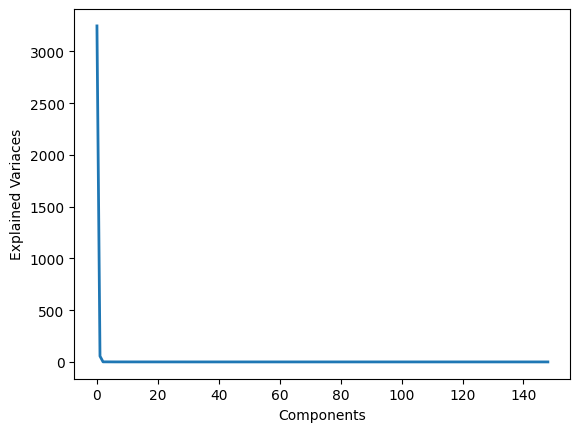

In [20]:
pca2 = PCA().fit(X)
plot(pca2.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variaces')
plt.show()

At around 2 components, the curve starts to stabilize. So, we'll use 2 components for PCA

In [21]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [22]:
print("After PCA....")
print(f"X Train shape: {X_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"y Test shape: {y_test.shape}")

After PCA....
X Train shape: (297, 2)
X Test shape: (75, 2)
y Train shape: (297,)
y Test shape: (75,)


In [24]:
regressors, param_grids = get_regressors_and_paramgrids()
results = {}

for name, model in regressors.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R² Score": r2}

Optimizing LinearRegression...
Best Parameters: {'fit_intercept': True}
Best Score: 0.0722568258860958
Optimizing RFR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
530 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, in

Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.0015435189550159572
Optimizing GBR...


/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8640 fits failed out of a total of 25920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4860 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/rittikar-s/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 666, 

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7}
Best Score: 0.0008497403455858261
Optimizing XGB...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score: 0.0016465532045260522


In [25]:
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R² Score = {scores['R² Score']:.4f}")

LinearRegression: RMSE = 0.2496, R² Score = 0.1053
RFR: RMSE = 0.0527, R² Score = 0.9601
GBR: RMSE = 0.0363, R² Score = 0.9811
XGB: RMSE = 0.0413, R² Score = 0.9754


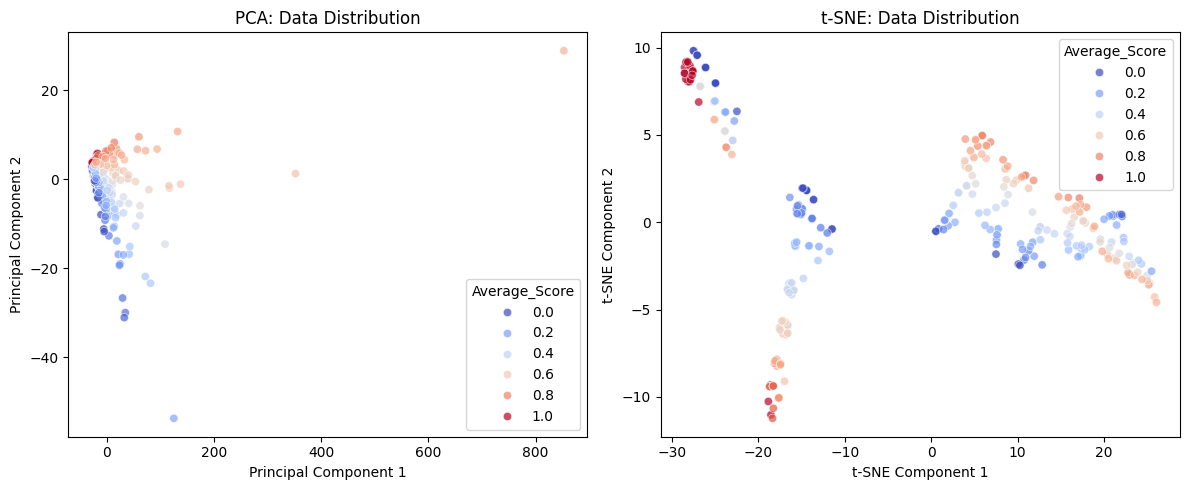

In [26]:
# Reduce to 2D using t-SNE (captures complex structure)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train)
X_tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_train)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y_train, palette="coolwarm", alpha=0.7)
plt.title("PCA: Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y_train, palette="coolwarm", alpha=0.7)
plt.title("t-SNE: Data Distribution")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

- The PCA1 and PCA2 don't clearly separate scores, suggesting that the features don't really strongly correleate in a linear way. This is the reason, why the Linear Regression didn't perform at par.
- This suggests that the Nonlinear models might perform better, which is evident from the RFR, GBR and XGB (the best).
- The tSNE plot does show some level of separation into clusters, if we look at the average scores. This suggests the feature similarity for the expected average score values. This is a very strong evidence, why the XGBoost worked better - it's linear and uses the Ensemble Boosting strategy. Also we did observe that the RandomForest also does decent. So Non-Linear models will always perform good on this data.